In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score
from sklearn.semi_supervised import LabelPropagation
from sklearn.linear_model import LogisticRegression
from metrics import f1_loss, BCE_loss, _eval_rocauc, ap_score

In [2]:
# Load data
labels = pd.read_csv('dataset/HumanGo/labels.csv', header=None).values
nodes = pd.read_csv('dataset/HumanGo/nodes.csv')
test_idx = pd.read_csv('dataset/HumanGo/test.txt').values.flatten()
train_idx = pd.read_csv('dataset/HumanGo/train.txt').values.flatten()
edge_list = pd.read_csv('dataset/HumanGo/edge_list.csv')
features = pd.read_csv('dataset/HumanGo/features.csv', header=None).values

# Prepare edge index and edge attributes
edge_index = torch.tensor(edge_list[['prot1', 'prot2']].values.T, dtype=torch.long)
edge_attr = torch.tensor(edge_list.iloc[:, 2:].values, dtype=torch.float)

# Prepare node features and labels
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.float)

# Split the data
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

# Create a PyG data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, train_mask=train_mask, test_mask=test_mask)
data

Data(x=[3106, 32], edge_index=[2, 18496], edge_attr=[18496, 21], y=[3106, 14], train_mask=[3106], test_mask=[3106])

In [3]:
G = nx.from_pandas_edgelist(edge_list, 'prot1', 'prot2')

# Compute and print dataset statistics
def print_dataset_info(G, labels):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    num_connected_components = nx.number_connected_components(G)
    largest_cc = max(nx.connected_components(G), key=len)
    num_nodes_lcc = len(largest_cc)
    num_edges_lcc = G.subgraph(largest_cc).number_of_edges()
    
    label_counts = np.sum(labels, axis=0)
    num_labels = labels.shape[1]
    label_distribution = dict(zip(range(num_labels), label_counts))

    print("Dataset Information: HumLoc")
    print(f"Total Nodes (Proteins): {num_nodes}")
    print(f"Total Edges (Protein-Protein Interactions): {num_edges}")
    print(f"Connected Components: {num_connected_components}")
    print(f"Largest Connected Component Nodes: {num_nodes_lcc}")
    print(f"Largest Connected Component Edges: {num_edges_lcc}")
    print(f"Labels: {num_labels} possible subcellular locations")
    print("Label Distribution:", label_distribution)

print_dataset_info(G, labels)


Dataset Information: HumLoc
Total Nodes (Proteins): 2589
Total Edges (Protein-Protein Interactions): 16508
Connected Components: 31
Largest Connected Component Nodes: 2552
Largest Connected Component Edges: 16472
Labels: 14 possible subcellular locations
Label Distribution: {0: 77.0, 1: 817.0, 2: 79.0, 3: 24.0, 4: 229.0, 5: 385.0, 6: 161.0, 7: 77.0, 8: 24.0, 9: 364.0, 10: 1021.0, 11: 47.0, 12: 354.0, 13: 22.0}


In [4]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return torch.sigmoid(x)

def train_gcn_with_history(model, data, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_loss = []
    train_acc = []
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = BCE_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        train_acc.append(((out[data.train_mask] > 0.5).float() == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item())
    return model, train_loss, train_acc

def BCE_loss(outputs: torch.Tensor, labels: torch.Tensor):
    loss = torch.nn.BCELoss()
    bce = loss(outputs, labels)
    return bce


In [15]:
class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, num_classes, heads=1, concat=True, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return torch.sigmoid(x)

def train_gat_with_history(model, data, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_loss = []
    train_acc = []
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = BCE_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        train_acc.append(((out[data.train_mask] > 0.5).float() == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item())
    return model, train_loss, train_acc


In [16]:
# Label Propagation
def label_propagation(data):
    lp_model = LabelPropagation()
    labels = data.y.argmax(axis=1).numpy()
    features = data.x.numpy()
    lp_model.fit(features[data.train_mask], labels[data.train_mask])
    lp_pred = lp_model.predict(features)
    
    # Convert to multi-label prediction
    lb = LabelBinarizer()
    lb.fit(labels)
    lp_pred = lb.transform(lp_pred)
    
    return lp_pred

In [17]:
def combine_predictions(lp_pred, gnn_pred, alpha=0.5):
    combined_pred = alpha * lp_pred + (1 - alpha) * gnn_pred
    return combined_pred

def evaluate_combined(lp_pred, gnn_model, data, alpha=0.5):
    gnn_model.eval()
    with torch.no_grad():
        logits = gnn_model(data)
        gnn_pred = logits[data.test_mask].sigmoid().cpu().numpy()
    
    # Convert to numpy arrays for compatibility with metrics.py
    combined_pred = combine_predictions(lp_pred[data.test_mask].numpy(), gnn_pred, alpha)
    labels = data.y[data.test_mask].numpy()
    
    # Ensure labels and combined_pred are converted to PyTorch tensors before calling f1_loss
    labels_tensor = torch.tensor(labels)
    combined_pred_tensor = torch.tensor(combined_pred)
    
    f1_micro = f1_loss(labels_tensor, combined_pred_tensor)[0]
    f1_macro = f1_loss(labels_tensor, combined_pred_tensor)[1]
    rocauc = _eval_rocauc(labels_tensor, combined_pred_tensor)
    ap = ap_score(labels_tensor, combined_pred_tensor)
    
    return f1_micro, f1_macro, rocauc, ap


In [18]:
# Evaluate label propagation
lp_pred_all = label_propagation(data)
lp_pred_all = torch.tensor(lp_pred_all, dtype=torch.float32)
lp_f1_micro, lp_f1_macro = f1_loss(data.y[data.test_mask], lp_pred_all[data.test_mask])
lp_rocauc = _eval_rocauc(data.y[data.test_mask], lp_pred_all[data.test_mask])
lp_ap = ap_score(data.y[data.test_mask], lp_pred_all[data.test_mask])


In [19]:
# Train and evaluate GCN
gcn_model = GCN(num_features=data.x.shape[1], num_classes=data.y.shape[1])
gcn_model, gcn_train_loss, gcn_train_acc = train_gcn_with_history(gcn_model, data)
gcn_model.eval()
with torch.no_grad():
    gcn_logits = gcn_model(data)
    gcn_pred = gcn_logits[data.test_mask].sigmoid().cpu().numpy()
gcn_f1_micro, gcn_f1_macro = f1_loss(data.y[data.test_mask], torch.tensor(gcn_pred))
gcn_rocauc = _eval_rocauc(data.y[data.test_mask], torch.tensor(gcn_pred))
gcn_ap = ap_score(data.y[data.test_mask], torch.tensor(gcn_pred))


In [20]:
# Train and evaluate GAT
gat_model = GAT(num_features=data.x.shape[1], num_classes=data.y.shape[1])
gat_model, gat_train_loss, gat_train_acc = train_gat_with_history(gat_model, data)
gat_model.eval()
with torch.no_grad():
    gat_logits = gat_model(data)
    gat_pred = gat_logits[data.test_mask].sigmoid().cpu().numpy()
gat_f1_micro, gat_f1_macro = f1_loss(data.y[data.test_mask], torch.tensor(gat_pred))
gat_rocauc = _eval_rocauc(data.y[data.test_mask], torch.tensor(gat_pred))
gat_ap = ap_score(data.y[data.test_mask], torch.tensor(gat_pred))


In [21]:
# Combine LP with GCN and GAT
combined_gcn_f1_micro, combined_gcn_f1_macro, combined_gcn_rocauc, combined_gcn_ap = evaluate_combined(lp_pred_all, gcn_model, data, alpha=0.5)
combined_gat_f1_micro, combined_gat_f1_macro, combined_gat_rocauc, combined_gat_ap = evaluate_combined(lp_pred_all, gat_model, data, alpha=0.5)


In [22]:
print(f"Label Propagation F1 Score: Micro={lp_f1_micro}, Macro={lp_f1_macro}, ROC-AUC={lp_rocauc}, AP={lp_ap}")
print(f"GCN F1 Score: Micro={gcn_f1_micro}, Macro={gcn_f1_macro}, ROC-AUC={gcn_rocauc}, AP={gcn_ap}")
print(f"GAT F1 Score: Micro={gat_f1_micro}, Macro={gat_f1_macro}, ROC-AUC={gat_rocauc}, AP={gat_ap}")
print(f"Combined LP and GCN F1 Score: Micro={combined_gcn_f1_micro}, Macro={combined_gcn_f1_macro}, ROC-AUC={combined_gcn_rocauc}, AP={combined_gcn_ap}")
print(f"Combined LP and GAT F1 Score: Micro={combined_gat_f1_micro}, Macro={combined_gat_f1_macro}, ROC-AUC={combined_gat_rocauc}, AP={combined_gat_ap}")

Label Propagation F1 Score: Micro=0.028668941979522185, Macro=0.011433341288238271, ROC-AUC=0.5004169878897397, AP=0.08460741802512652
GCN F1 Score: Micro=0.1863481228668942, Macro=0.0932651527982228, ROC-AUC=0.5314090977204594, AP=0.11055162382254291
GAT F1 Score: Micro=0.26621160409556316, Macro=0.08276346269225021, ROC-AUC=0.5064796498007306, AP=0.09779309994967976
Combined LP and GCN F1 Score: Micro=0.04505119453924915, Macro=0.022595862639945525, ROC-AUC=0.5319620248586063, AP=0.11159450366883338
Combined LP and GAT F1 Score: Micro=0.11126279863481228, Macro=0.060599432938295825, ROC-AUC=0.5068246130159721, AP=0.09880999140940795


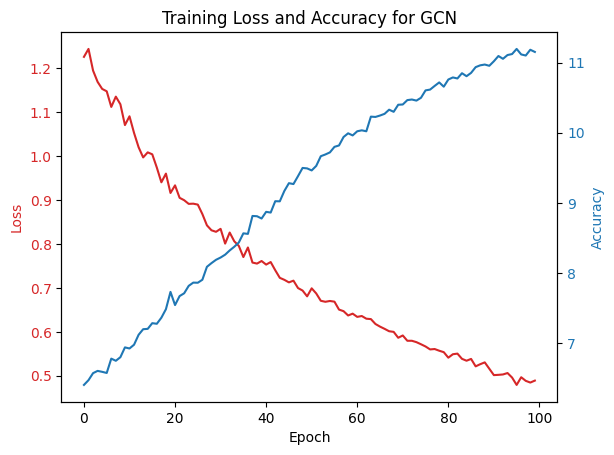

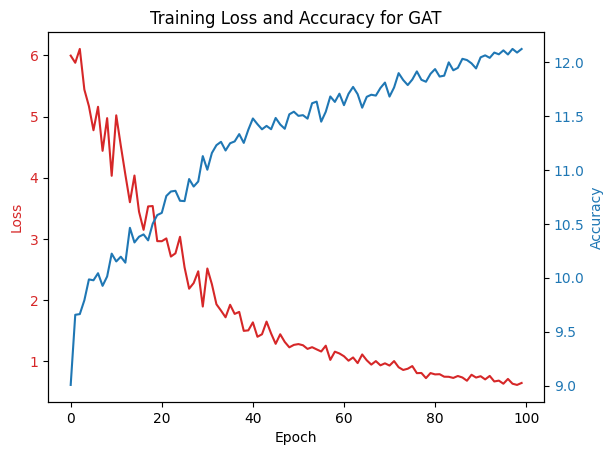

In [23]:
def plot_training_history(train_loss, train_acc, model_name):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(train_loss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(train_acc, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'Training Loss and Accuracy for {model_name}')
    plt.show()

# Plot training history for GCN, GAT, and combined models
plot_training_history(gcn_train_loss, gcn_train_acc, 'GCN')
plot_training_history(gat_train_loss, gat_train_acc, 'GAT')


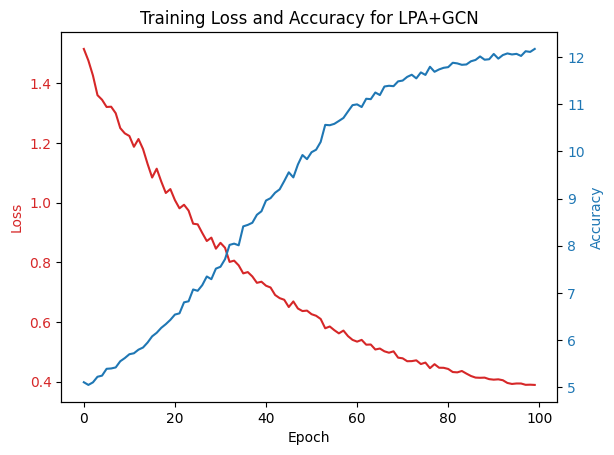

LPA+GCN - Micro F1: 0.2839590443686007, Macro F1: 0.09447968198923781, ROC-AUC: 0.48695282117430516, AP: 0.09404535008136065


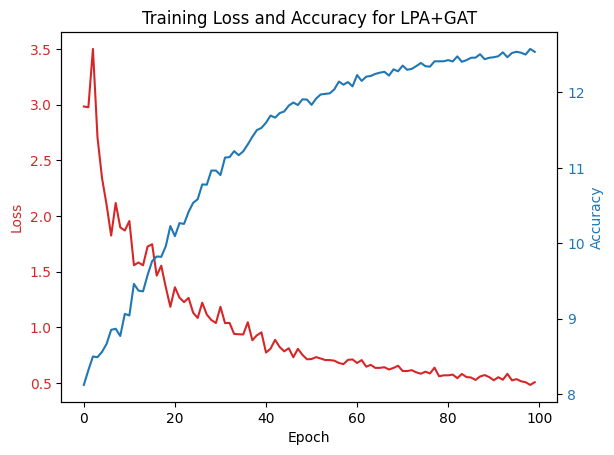

LPA+GAT - Micro F1: 0.3460750853242321, Macro F1: 0.11147962029377215, ROC-AUC: 0.49976752499485994, AP: 0.10515338025248012


In [24]:
def train_combined_gcn_with_history(model, data, lp_labels, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_loss = []
    train_acc = []
    model.train()
    lp_labels = lp_labels.float() 
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = BCE_loss(out[data.train_mask], lp_labels[data.train_mask])
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        train_acc.append(((out[data.train_mask] > 0.5).float() == lp_labels[data.train_mask]).sum().item() / data.train_mask.sum().item())
    return model, train_loss, train_acc

def BCE_loss(outputs: torch.Tensor, labels: torch.Tensor):
    loss = torch.nn.BCELoss()
    bce = loss(outputs, labels)
    return bce

lp_labels = torch.tensor(lp_pred_all, dtype=torch.long)  # Convert LP labels to tensor
gcn_model = GCN(num_features=data.x.shape[1], num_classes=data.y.shape[1])
combined_gcn_model, combined_gcn_train_loss, combined_gcn_train_acc = train_combined_gcn_with_history(gcn_model, data, lp_labels)
combined_gcn_model.eval()
with torch.no_grad():
    combined_gcn_logits = combined_gcn_model(data)
    combined_gcn_pred = combined_gcn_logits[data.test_mask].sigmoid().cpu().numpy()
combined_gcn_f1_micro, combined_gcn_f1_macro = f1_loss(data.y[data.test_mask], torch.tensor(combined_gcn_pred))
combined_gcn_rocauc = _eval_rocauc(data.y[data.test_mask], torch.tensor(combined_gcn_pred))
combined_gcn_ap = ap_score(data.y[data.test_mask], torch.tensor(combined_gcn_pred))

plot_training_history(combined_gcn_train_loss, combined_gcn_train_acc, "LPA+GCN")
print(f"LPA+GCN - Micro F1: {combined_gcn_f1_micro}, Macro F1: {combined_gcn_f1_macro}, ROC-AUC: {combined_gcn_rocauc}, AP: {combined_gcn_ap}")

def train_combined_gat_with_history(model, data, lp_labels, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_loss = []
    train_acc = []
    model.train()
    lp_labels = lp_labels.float() 
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = BCE_loss(out[data.train_mask], lp_labels[data.train_mask])
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        train_acc.append(((out[data.train_mask] > 0.5).float() == lp_labels[data.train_mask]).sum().item() / data.train_mask.sum().item())
    return model, train_loss, train_acc

gat_model = GAT(num_features=data.x.shape[1], num_classes=data.y.shape[1])
combined_gat_model, combined_gat_train_loss, combined_gat_train_acc = train_combined_gat_with_history(gat_model, data, lp_labels)
combined_gat_model.eval()
with torch.no_grad():
    combined_gat_logits = combined_gat_model(data)
    combined_gat_pred = combined_gat_logits[data.test_mask].sigmoid().cpu().numpy()
combined_gat_f1_micro, combined_gat_f1_macro = f1_loss(data.y[data.test_mask], torch.tensor(combined_gat_pred))
combined_gat_rocauc = _eval_rocauc(data.y[data.test_mask], torch.tensor(combined_gat_pred))
combined_gat_ap = ap_score(data.y[data.test_mask], torch.tensor(combined_gat_pred))

plot_training_history(combined_gat_train_loss, combined_gat_train_acc, "LPA+GAT")
print(f"LPA+GAT - Micro F1: {combined_gat_f1_micro}, Macro F1: {combined_gat_f1_macro}, ROC-AUC: {combined_gat_rocauc}, AP: {combined_gat_ap}")